With a new dataset, only modifying the following shall be sufficient. 
* Import Data
    * directory
    * file name
    * pd.read_csv() if different file type
    * data_name
    * label_name
* Prepare Data
    * In get_train_data function, modify the way binary labels are defined.
    * Number of posts (iterations) in get_word_data based on your interest
* Results
    * Modify the way 'keyword' is used based on your binary labels.

# Import Data

In [1]:
import pandas as pd

In [2]:
directory = '/data2/link10/data/nrc/'
file_name = 'msgs_tec.csv'
raw_df = pd.read_csv(directory + file_name)
# remove rows with missing values
df = raw_df.dropna()
df.head()

,message_id,message,emotion
0,145353048817012736,Thinks that @melbahughes had a great 50th birt...,surprise
1,144279638024257536,"Como una expresiÃ³n tan simple, una sola oraci...",sadness
2,140499585285111809,the moment when you get another follower and y...,joy
3,145207578270507009,Be the greatest dancer of your life! practice ...,joy
4,139502146390470656,eww.. my moms starting to make her annual rum ...,disgust


In [3]:
data_name = 'message'
label_name = 'emotion'

In [4]:
print(
    'There are {} data.'.format(df.shape[0]),
    'Labels are: {}'.format(df[label_name].unique()),
    sep = '\n'
    )
df[label_name].value_counts()

There are 21049 data.
Labels are: ['surprise' 'sadness' 'joy' 'disgust' 'fear' 'anger']


joy         8239
surprise    3849
sadness     3829
fear        2816
anger       1555
disgust      761
Name: emotion, dtype: int64

# Embedding

In [5]:
# !python -m spacy download en_core_web_lg
import numpy as np
import spacy

In [6]:
# # load the language model
# nlp = spacy.load('en_core_web_lg')

In [7]:
# with nlp.disable_pipes():
#     msg_vectors = np.array([nlp(msg.lower()).vector for msg in tqdm(df[data_name])])
# msg_vectors.shape

In [8]:
# nrc_glove_vectors = msg_vectors
# %store nrc_glove_vectors

In [9]:
# embedding takes huge amount of time, use stored result
%store -r nrc_glove_vectors
msg_vectors = nrc_glove_vectors
msg_vectors.shape

(21049, 300)

# Play with data

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

<AxesSubplot:xlabel='emotion', ylabel='count'>

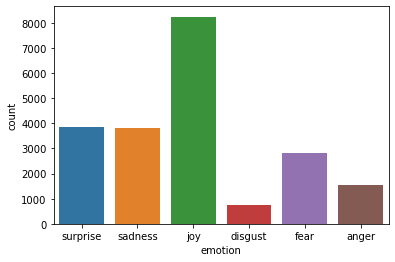

In [12]:
import seaborn as sb
import matplotlib.pyplot as plt
sb.countplot(x = label_name, data=df)

In [13]:
keyword = 'joy'

In [14]:
labels = np.array([1 if x == keyword else 0 for x in df[label_name]])
X_train, X_test, y_train, y_test = train_test_split(msg_vectors, labels,
                                                    test_size=0.2, random_state=1)

In [15]:
# # Standardize Input (skip for now)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [16]:
# X_train_ts = torch.from_numpy(X_train).type(torch.FloatTensor)
# Y_train_ts = torch.from_numpy(Y_train).type(torch.LongTensor)
# X_test_ts = torch.from_numpy(X_test).type(torch.FloatTensor)

# Set up Neural Network

In [17]:
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [18]:
## train data
class trainData(Dataset):    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

In [19]:
## test data
class testData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = testData(torch.FloatTensor(X_test))

In [20]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)#
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [21]:
# 2 layer Feed-Forward network with BatchNorm and Dropout
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(300, 1024) 
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 128)
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
#         self.batchnorm1 = nn.BatchNorm1d(512)
#         self.batchnorm2 = nn.BatchNorm1d(512)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [22]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [23]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


# Train the model

In [24]:

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [25]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.55152 | Acc: 72.356
Epoch 002: | Loss: 0.49295 | Acc: 76.682
Epoch 003: | Loss: 0.47446 | Acc: 78.008
Epoch 004: | Loss: 0.44886 | Acc: 79.515
Epoch 005: | Loss: 0.43047 | Acc: 80.447
Epoch 006: | Loss: 0.40220 | Acc: 81.886
Epoch 007: | Loss: 0.37242 | Acc: 83.333
Epoch 008: | Loss: 0.34473 | Acc: 84.826
Epoch 009: | Loss: 0.31836 | Acc: 86.076
Epoch 010: | Loss: 0.29593 | Acc: 87.167


# Test the model

In [26]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [27]:
confusion_matrix(y_test, y_pred_list)

array([[2017,  517],
       [ 442, 1234]])

In [28]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2534
           1       0.70      0.74      0.72      1676

    accuracy                           0.77      4210
   macro avg       0.76      0.77      0.76      4210
weighted avg       0.77      0.77      0.77      4210



# Results

In [29]:
# word_list, word_array, word_occr = get_word_data(nlp,df)

In [30]:
# nrc_glove_word = [word_list, word_array, word_occr]
# %store nrc_glove_word

In [31]:
# use stored result
%store -r nrc_glove_word
word_list = nrc_glove_word[0]
word_array = nrc_glove_word[1]
word_occr = nrc_glove_word[2]

In [32]:
## word data
class wordData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
word_data = wordData(torch.FloatTensor(word_array))

In [33]:
word_loader = DataLoader(dataset=word_data, batch_size=1)

In [34]:
from tqdm import tqdm
word_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in tqdm(word_loader):
        X_batch = X_batch.to(device)
        word_pred = model(X_batch)
#         word_pred = torch.sigmoid(word_pred)
        word_pred_list.append(word_pred.cpu().numpy())
word_pred_list = [a.squeeze().tolist() for a in word_pred_list]

100%|██████████| 33457/33457 [00:16<00:00, 2013.33it/s]


In [35]:
top_words = pd.DataFrame({'word':word_list,'pred':word_pred_list,'occurrence':word_occr})
top_words = top_words.sort_values('pred',ascending=False)

In [36]:
thresh = 20
pos_words_f = top_words[top_words['occurrence']>thresh]

In [37]:
# joy
pos_words_f.head(20)

,word,pred,occurrence
233,joy,101.101479,323
6244,joyful,97.709732,25
7388,blessings,84.334053,21
795,happiness,73.874496,139
1549,train,69.651146,59
684,laughter,65.910011,24
3237,essay,64.161926,69
5143,gratitude,62.377506,29
5218,blessed,60.317436,46
213,gravy,57.092125,26


In [38]:
neg_words_f  = pos_words_f.sort_values('pred',ascending=True)
neg_words_f.head(20)

,word,pred,occurrence
385,fear,-75.341156,365
696,scared,-71.888382,124
1340,unexpected,-65.836662,21
3700,won,-64.642807,35
8161,mo,-63.053478,22
5025,une,-62.190647,53
3664,sur,-60.928333,43
1503,afraid,-60.705723,422
2485,scary,-54.605537,21
1956,ma,-54.097271,79
